## Druga część projektu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

### wczytanie wszystkich zbiorow danych i podział na zbiór testowy i treningowy

In [2]:
split_ratio = 0.8
train_datasets = {}
test_datasets = {}

for name in ["mean_min_max", "median_min_max", "knn_min_max", "mean_standard", "median_standard", "knn_standard"]:
    df = pd.read_csv(f"{name}.csv")
    
    df = shuffle(df, random_state=42).reset_index(drop=True)
    
    split_index = int(len(df) * split_ratio)
    
    train_datasets[name] = df[:split_index]
    test_datasets[name] = df[split_index:]

for name in train_datasets:
    print(f"{name} - Zbiór treningowy: {train_datasets[name].shape}, Zbiór testowy: {test_datasets[name].shape}")

mean_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
median_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
knn_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
mean_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
median_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
knn_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)


### dwa podstawowe modele regresji

In [3]:
linear_regression_results = {}

for name in train_datasets:
    X_train = train_datasets[name].drop(columns=["sellingprice"])
    y_train = train_datasets[name]["sellingprice"]
    X_test = test_datasets[name].drop(columns=["sellingprice"])
    y_test = test_datasets[name]["sellingprice"]

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    y_pred = linear_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    linear_regression_results[name] = {
        "MSE": mse,
        "R^2": r2
    }

    print(f"Regresja Liniowa - Zbiór: {name}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R^2 Score: {r2:.2f}")
    print("-" * 30)


Regresja Liniowa - Zbiór: mean_min_max
Mean Squared Error: 0.0018
R^2 Score: 0.96
------------------------------
Regresja Liniowa - Zbiór: median_min_max
Mean Squared Error: 0.0018
R^2 Score: 0.96
------------------------------
Regresja Liniowa - Zbiór: knn_min_max
Mean Squared Error: 0.0018
R^2 Score: 0.96
------------------------------
Regresja Liniowa - Zbiór: mean_standard
Mean Squared Error: 0.0357
R^2 Score: 0.96
------------------------------
Regresja Liniowa - Zbiór: median_standard
Mean Squared Error: 0.0357
R^2 Score: 0.96
------------------------------
Regresja Liniowa - Zbiór: knn_standard
Mean Squared Error: 0.0357
R^2 Score: 0.96
------------------------------


In [4]:
random_forest_results = {}

for name in train_datasets:
    X_train = train_datasets[name].drop(columns=["sellingprice"])
    y_train = train_datasets[name]["sellingprice"]
    X_test = test_datasets[name].drop(columns=["sellingprice"])
    y_test = test_datasets[name]["sellingprice"]

    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    random_forest_results[name] = {
        "MSE": mse,
        "R^2": r2
    }

    print(f"Random Forest - Zbiór: {name}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R^2 Score: {r2:.2f}")
    print("-" * 30)

Random Forest - Zbiór: mean_min_max
Mean Squared Error: 0.0015
R^2 Score: 0.97
------------------------------
Random Forest - Zbiór: median_min_max
Mean Squared Error: 0.0015
R^2 Score: 0.97
------------------------------
Random Forest - Zbiór: knn_min_max
Mean Squared Error: 0.0015
R^2 Score: 0.97
------------------------------
Random Forest - Zbiór: mean_standard
Mean Squared Error: 0.0311
R^2 Score: 0.97
------------------------------
Random Forest - Zbiór: median_standard
Mean Squared Error: 0.0310
R^2 Score: 0.97
------------------------------
Random Forest - Zbiór: knn_standard
Mean Squared Error: 0.0311
R^2 Score: 0.97
------------------------------


Regresja liniowa wykonuje się bardzo szybko, las losowy bardzo długo - dla każdego zbioru kilkanaście/kilkadziesiąt minut.

### wizualizacja wynikow

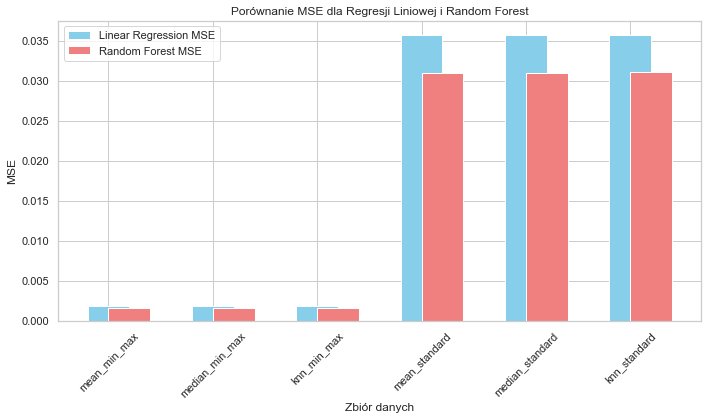

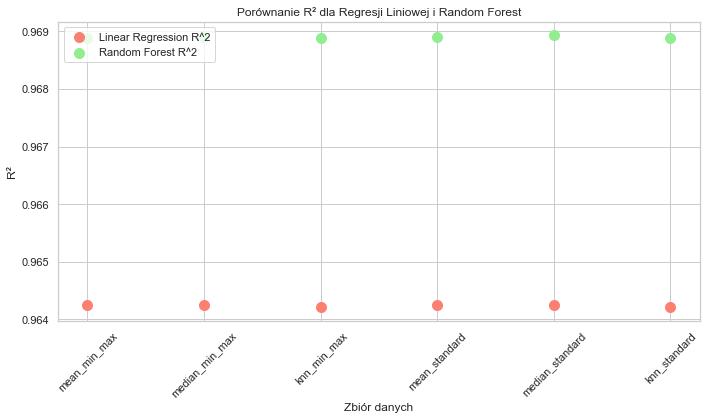

In [18]:
sns.set(style="whitegrid")

def plot_comparison_metrics(linear_regression_results, random_forest_results):
    datasets = list(linear_regression_results.keys())
    
    mse_lr = [linear_regression_results[dataset]['MSE'] for dataset in datasets]
    r2_lr = [linear_regression_results[dataset]['R^2'] for dataset in datasets]
    
    mse_rf = [random_forest_results[dataset]['MSE'] for dataset in datasets]
    r2_rf = [random_forest_results[dataset]['R^2'] for dataset in datasets]
    
    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    plt.bar(datasets, mse_lr, width=bar_width, label="Linear Regression MSE", color="skyblue", align='center')
    plt.bar(datasets, mse_rf, width=bar_width, label="Random Forest MSE", color="lightcoral", align='edge')
    
    plt.xlabel('Zbiór danych')
    plt.ylabel('MSE')
    plt.title('Porównanie MSE dla Regresji Liniowej i Random Forest')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(datasets, r2_lr, label="Linear Regression R^2", color="salmon", s=100, zorder=5)
    plt.scatter(datasets, r2_rf, label="Random Forest R^2", color="lightgreen", s=100, zorder=5)

    plt.xlabel('Zbiór danych')
    plt.ylabel('R²')
    plt.title('Porównanie R² dla Regresji Liniowej i Random Forest')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_comparison_metrics(linear_regression_results, random_forest_results)